In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://github.com/falsefoobar/CS381/blob/main/diabetes.csv?raw=True"
df = pd.read_csv(url)

df.shape

(768, 9)

In [50]:
# Making copy to not tamper with raw sliced data
df_processed = df.copy()

# Listing columns where 0 is an implausible value
implausible_zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for column in implausible_zero_columns:
    df_processed[column] = df_processed[column].replace(0, np.nan)

print("Missing Values in Each Column After Converting 0s to NaN:")
print(df_processed.isnull().sum())
print("Percentage of Missing Values After Converting 0s to NaN:")
print((df_processed.isnull().sum() / len(df_processed)) * 100)


Missing Values in Each Column After Converting 0s to NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Percentage of Missing Values After Converting 0s to NaN:
Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64


In [51]:
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

df_knn_imputed = df_processed.copy()

# Read that applying KNNImputer to all numerical columns to impute
all_numerical_cols = df_processed.select_dtypes(include=np.number).columns.tolist()
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed[all_numerical_cols] = knn_imputer.fit_transform(df_knn_imputed[all_numerical_cols])

print("Missing Values in Each Column After KNN Imputation:")
print(df_knn_imputed.isnull().sum()[df_knn_imputed.isnull().sum() > 0])

Missing Values in Each Column After KNN Imputation:
Series([], dtype: int64)


#Up-sampled BMI under 25, 25-29 and over 30

In [52]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Create BMI categories
def bmi_category(bmi):
    if bmi <= 25:
        return 'Under 25'
    elif 25 < bmi < 30:
        return '25–29'
    else:
        return 'Over 30'

# Apply BMI categorization
df_knn_imputed['BMI_Category'] = df_knn_imputed['BMI'].apply(bmi_category)

print(df_knn_imputed['BMI_Category'].value_counts())

# Separate the data into BMI <= 25 and BMI > 25 categories
df_bmi_under_25 = df_knn_imputed[df_knn_imputed['BMI_Category'] == 'Under 25']
df_bmi_over_25 = df_knn_imputed[df_knn_imputed['BMI_Category'] != 'Under 25']

# Up-sample the BMI <= 25 group

df_bmi_under_25_upsampled = resample(df_bmi_under_25,
                                     replace=True,    # Sample with replacement
                                     n_samples=len(df_bmi_over_25),  # Match the size of the overrepresented class
                                     random_state=42)  # For reproducibility
# Combine the up-sampled data with the BMI > 25 group
df_balanced = pd.concat([df_bmi_over_25, df_bmi_under_25_upsampled])

# Prepare features (BMI) and target (Outcome)
X_balanced = df_balanced[['BMI']]  # Feature: BMI
y_balanced = df_balanced['Outcome']  # Target: Outcome (0 = No Diabetes, 1 = Has Diabetes)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale the BMI feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train the logistic regression model with class_weight='balanced'
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


BMI_Category
Over 30     477
25–29       179
Under 25    112
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       199
         1.0       0.49      0.72      0.58        64

    accuracy                           0.75       263
   macro avg       0.69      0.74      0.70       263
weighted avg       0.80      0.75      0.76       263

Confusion Matrix:
 [[151  48]
 [ 18  46]]


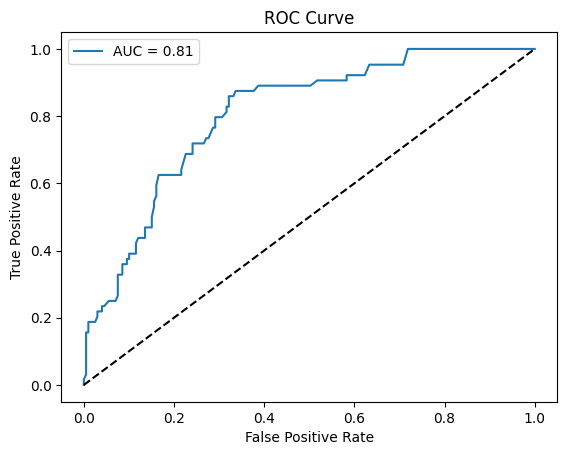

In [53]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Add feature glucose

In [54]:
# Prepare features (BMI and Glucose) and target (Outcome)
X_balanced = df_balanced[['BMI', 'Glucose']]  # Include both BMI and Glucose
y_balanced = df_balanced['Outcome']  # Target: Outcome (0 = No Diabetes, 1 = Has Diabetes)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale both BMI and Glucose features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       199
         1.0       0.56      0.72      0.63        64

    accuracy                           0.79       263
   macro avg       0.73      0.77      0.74       263
weighted avg       0.82      0.79      0.80       263

Confusion Matrix:
 [[163  36]
 [ 18  46]]


AUC: 0.8810


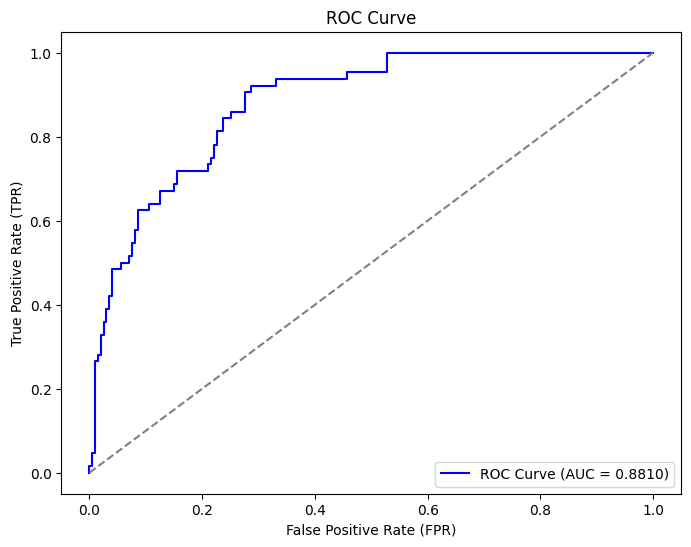

In [55]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (Outcome = 1)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Calculate ROC curve values (fpr: false positive rate, tpr: true positive rate)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

#Add feature Insulin

In [60]:
X_balanced = df_balanced[['BMI', 'Glucose', 'Insulin']]  # Now include BMI, Glucose, and Insulin
y_balanced = df_balanced['Outcome']  # Target: Outcome (0 = No Diabetes, 1 = Has Diabetes)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale BMI, Glucose, and Insulin features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       199
         1.0       0.56      0.72      0.63        64

    accuracy                           0.79       263
   macro avg       0.73      0.77      0.74       263
weighted avg       0.82      0.79      0.80       263

Confusion Matrix:
 [[163  36]
 [ 18  46]]


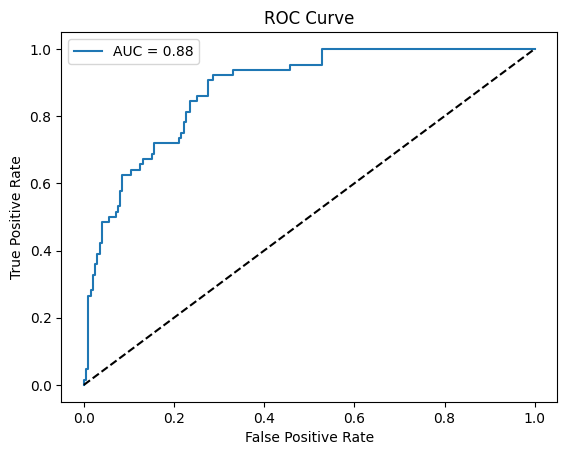

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [62]:
X_balanced = df_balanced[['BMI', 'Glucose', 'Age']]  # Include BMI, Glucose, and Age (no Insulin)
y_balanced = df_balanced['Outcome']  # Target: Outcome (0 = No Diabetes, 1 = Has Diabetes)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Scale BMI, Glucose, and Age features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model with class_weight='balanced'
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.84      0.88       199
         1.0       0.61      0.75      0.67        64

    accuracy                           0.82       263
   macro avg       0.76      0.80      0.77       263
weighted avg       0.84      0.82      0.83       263

Confusion Matrix:
 [[168  31]
 [ 16  48]]


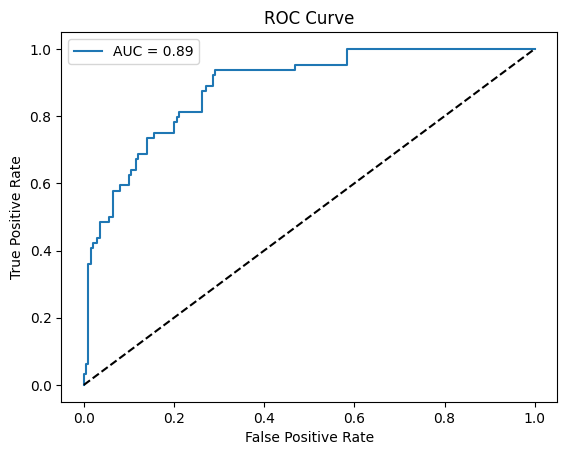

In [63]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Counting BMI Categories

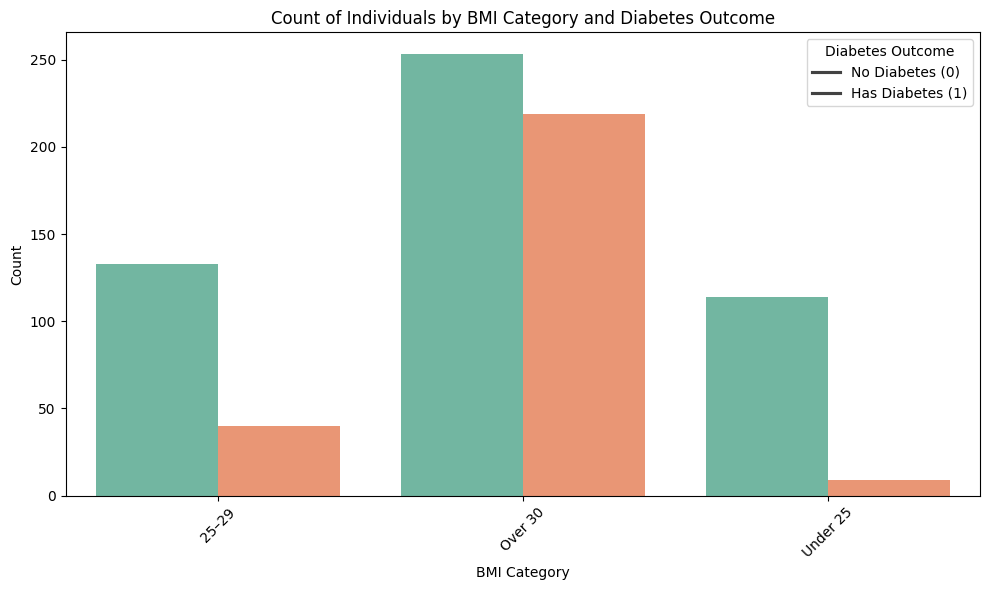

In [65]:
# Step 1: Create BMI categories
def bmi_category(bmi):
    if bmi <= 25:
        return 'Under 25'
    elif 25 < bmi < 30:
        return '25–29'
    else:
        return 'Over 30'

# Apply BMI categorization
df['BMI_Category'] = df['BMI'].apply(bmi_category)

# Step 2: Group by Outcome and BMI Category and count the occurrences
grouped_count = df.groupby(['Outcome', 'BMI_Category']).size().reset_index(name='Count')

# Step 3: Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_count, x='BMI_Category', y='Count', hue='Outcome', palette='Set2')

# Formatting
plt.title('Count of Individuals by BMI Category and Diabetes Outcome')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Diabetes Outcome', labels=['No Diabetes (0)', 'Has Diabetes (1)'])
plt.tight_layout()
plt.show()

In [71]:
# Filter the dataset for people with BMI over 30
df_bmi_over_30 = df[df['BMI_Category'] == 'Over 30']

# Calculate the count of diabetics (Outcome = 1) and non-diabetics (Outcome = 0)
bmi_over_30_counts = df_bmi_over_30['Outcome'].value_counts()

# Calculate the ratio of diabetics
diabetics_ratio = bmi_over_30_counts[1] / len(df_bmi_over_30)  # Outcome = 1 (diabetics)

print(f"Ratio of diabetics (BMI > 30): {diabetics_ratio:.2f}")


Ratio of diabetics (BMI > 30): 0.46


THe ratio between non diabetics and diabetics is 0.46 when the BMI is over 30. This showers a great significance of BMI with our outcome.

This data will need to be balanced to ensure that the model does not become biased towards predicting the outcome for this group.

According to the CDC, a healthy weight 18.5 to less than 25. Everything over 30 BMI is considered obesity.

*Adult BMI Categories*, from CDC. https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html

##Observing  Pregnacies and mean BMI

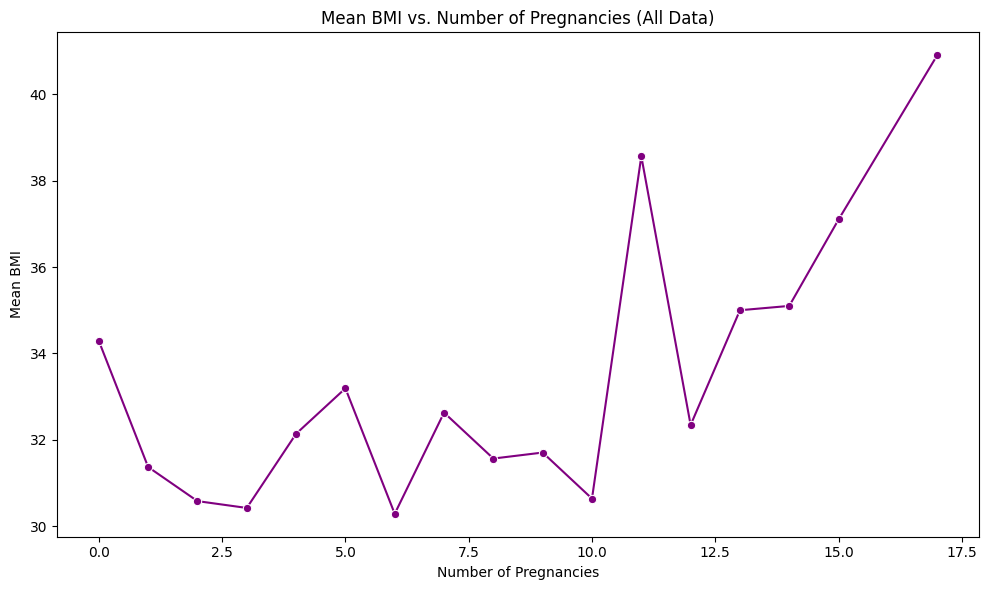

In [66]:
# Group by 'Pregnancies' and calculate mean BMI
mean_bmi_all = df.groupby('Pregnancies')['BMI'].mean().reset_index()

# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_bmi_all, x='Pregnancies', y='BMI', marker='o', color='purple')

# Formatting
plt.title('Mean BMI vs. Number of Pregnancies (All Data)')
plt.xlabel('Number of Pregnancies')
plt.ylabel('Mean BMI')
plt.grid(axis='y', linestyle='--', alpha=0.)
plt.tight_layout()
plt.show()

We see here that the average BMI jumps around.

In [67]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
_, p_value = pearsonr(df['BMI'], df['Pregnancies'])

print(f"P-value: {p_value:.4f}")

P-value: 0.6246


According to the p value,  we cannot reject that there is no correlation between BMI and number of pregnancies.

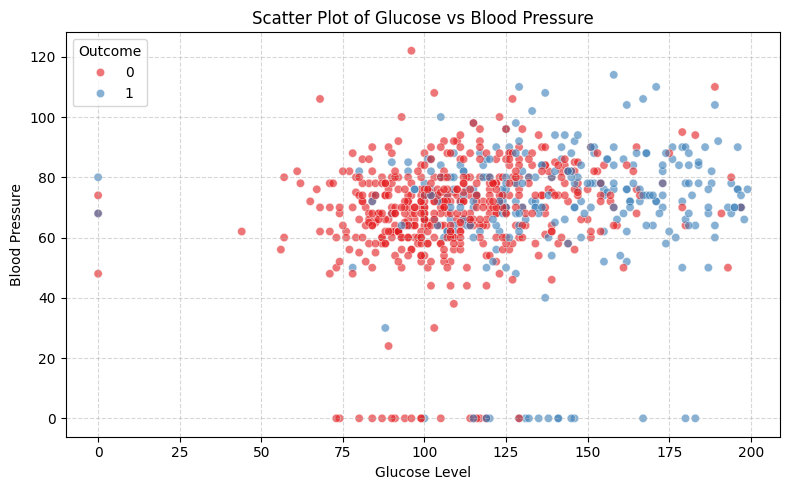

In [68]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Glucose', y='BloodPressure', hue='Outcome', alpha=0.6, palette='Set1')
plt.title('Scatter Plot of Glucose vs Blood Pressure')
plt.xlabel('Glucose Level')
plt.ylabel('Blood Pressure')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Blood pressure may be affect by affected  level overtime, but it does not help in showing diabetes.